# Deploying a Neural Network Based Monitoring Service

Most of the content in this notebook comes from 1-Incubator-Service, adjusted to deploy the `temperature_prediction_model.py`.

So we have fewer explanations.

We are going to deploy the NNBasedMonitoringService which uses the trained NN to give predictions, and then compares the predictions with actual temperatures, and reconfigures PTController if they diverge.

In [1]:
# Configure python path to load incubator modules
import sys
import os

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '3-Physics-Modelling', 'Current directory is not 3-Physics-Modelling'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

In [2]:
%%writefile logging.conf
[loggers]
keys=root,NNBasedMonitoringService

[handlers]
keys=consoleHandler,NNBasedMonitoringServiceFileHandler

[formatters]
keys=simpleFormatter

[logger_root]
level=DEBUG
handlers=consoleHandler

[logger_NNBasedMonitoringService]
level=DEBUG
handlers=NNBasedMonitoringServiceFileHandler
qualname=NNBasedMonitoringService
propagate=0

[handler_consoleHandler]
class=StreamHandler
formatter=simpleFormatter
args=(sys.stdout,)

[handler_NNBasedMonitoringServiceFileHandler]
class=FileHandler
formatter=simpleFormatter
args=('NNBasedMonitoringService.log', 'w')

[formatter_simpleFormatter]
format=%(asctime)s.%(msecs)03d %(levelname)s %(name)s : %(message)s
datefmt=%Y-%m-%d %H:%M:%S

Overwriting logging.conf


In [3]:
%%writefile start_incubator.py
# Configure python path to load incubator modules
import sys
import os
from collections import deque

# Get the current working directory. Should be 3-Physics-Modelling
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '3-Physics-Modelling', 'Current directory is not 3-Physics-Modelling'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

# Append the same path to PYTHONPATH
os.environ['PYTHONPATH'] = os.pathsep.join([os.environ.get('PYTHONPATH', ''), incubator_dt_software_dir])

from startup.start_docker_influxdb import start_docker_influxdb
from startup.start_docker_rabbitmq import start_docker_rabbitmq
from startup.start_incubator_realtime_mockup import start_incubator_realtime_mockup
from startup.start_influx_data_recorder import start_influx_data_recorder
from startup.start_low_level_driver_mockup import start_low_level_driver_mockup
from startup.start_controller_physical import start_controller_physical
from startup.utils.start_as_daemon import start_as_daemon

if __name__ == '__main__':
    start_docker_rabbitmq()
    start_docker_influxdb()

    start_as_daemon(start_incubator_realtime_mockup)
    start_as_daemon(start_low_level_driver_mockup)
    start_as_daemon(start_influx_data_recorder)
    start_as_daemon(start_controller_physical)


Overwriting start_incubator.py


Open a terminal and run: `python start_incubator.py`.
Leaving it running and move to the next cell.

In [17]:
%%writefile temperature_prediction_service.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time
from collections import deque

from temperature_prediction_model import IncubatorPredictionNN 

# Get the current working directory. Should be 3-Physics-Modelling
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '3-Physics-Modelling', 'Current directory is not 3-Physics-Modelling'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

from incubator.communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS
from incubator.communication.server.rabbitmq import Rabbitmq, from_ns_to_s

class NNBasedMonitoringService:
    def __init__(self, max_diff, safe_temp, rabbitmq_config):
        self._l = logging.getLogger("NNBasedMonitoringService")

        self._max_diff = max_diff # Maximum tolerated difference.
        assert self._max_diff > 0, "max_diff must be greater than 0."
        self._safe_temp = safe_temp # Safe temperature to set controller to.

        # Check that temperature_prediction_model.pth file exists:
        model_path = "temperature_prediction_model.pth"
        assert os.path.exists(model_path), f'{model_path} not found'
        self.temperature_prediction_model = IncubatorPredictionNN(model_path)
        self.rabbitmq = Rabbitmq(**rabbitmq_config)

        # current and previous inputs to NN
        self.past_time = None
        self.past_Tb = None
        self.past_room_Temp = None
        self.past_heater_state = None
        self.current_time = None
        self.current_Tb = None
        self.current_room_Temp = None
        self.current_heater_state = None
        self.predicted_Tb = None
        self.prediction_error = None

    def _record_message(self, message):
        # Check that time_step is still matching the dataset timestep. If the timestep changes, the NN has to be retrained.
        time_step = message['fields']['execution_interval'] # s

        assert abs(time_step - 3.0) < 0.1, "time_step does not match the dataset timestep. If the timestep changes, the NN has to be retrained."

        if self.current_time is None: # No message seen so far
            self._l.info(f"First message received.")
            assert self.past_time is None

            self.current_time = message['time'] # ns
            self.current_Tb = message['fields']['average_temperature']
            self.current_room_Temp = message['fields']['t3']
            self.current_heater_state = 1 if message["fields"]["heater_on"] else 0
        else:
            self.past_time = self.current_time
            self.past_Tb = self.current_Tb
            self.past_room_Temp = self.current_room_Temp
            self.past_heater_state = self.current_heater_state

            self.current_time = message['time'] # ns
            self.current_Tb = message['fields']['average_temperature']
            self.current_room_Temp = message['fields']['t3']
            self.current_heater_state = 1 if message["fields"]["heater_on"] else 0
            # Check that the messages are separated by time_step

            assert message['time'] >= self.current_time
            new_msg_time_diff = from_ns_to_s(message['time'] - self.current_time) # s
            new_msg_time_bigger_than_step = new_msg_time_diff > time_step + 0.1

            if new_msg_time_bigger_than_step:
                self._l.warn(f"New message received is too far apart from previous message: difference={new_msg_time_diff}s, last_timestamp={self.current_time}ns, new_timestamp={message['time']}ns")
                self.current_time = message['time'] # ns
                self.current_Tb = message['fields']['average_temperature']
                self.current_room_Temp = message['fields']['t3']
                self.current_heater_state = 1 if message["fields"]["heater_on"] else 0

                # Drop all records. This will force service to wait for 2 new messages that are contiguous.
                self.past_time = None
                self.past_Tb = None
                self.past_room_Temp = None
                self.past_heater_state = None

                self.current_time = None
                self.current_Tb = None
                self.current_room_Temp = None
                self.current_heater_state = None

    def setup(self):
        self.rabbitmq.connect_to_server()
        self.rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.control_loop_callback)
        self._l.info("setup complete.")

    def prediction_step(self):
        self._l.debug("step")

        # Recall that the network predicts the next temperature, so we use the previous values to make the prediction.
        if self.current_time is not None and self.past_time is not None:
            assert self.current_Tb is not None
            assert self.past_Tb is not None
            assert self.past_room_Temp is not None
            assert self.past_heater_state is not None

            self.temperature_prediction_model.predict_Tb(self.past_Tb, self.past_room_Temp, self.past_heater_state)
            self.predicted_Tb = self.temperature_prediction_model.get_Tb()
            self.prediction_error = self.current_Tb - self.predicted_Tb
            self._l.debug(f"prediction step done. Time(ns): {self.current_time}, Heater: {self.past_heater_state}, Temp: {self.past_Tb}, Room Temp: {self.past_room_Temp}, New Temperature: {self.predicted_Tb}")
        else:
            self._l.debug(f"prediction not step done yet. Waiting for more data.")

    def cleanup(self):
        self.rabbitmq.close()

    def upload_state(self):
        if self.current_time is not None and self.past_time is not None:
            assert self.predicted_Tb is not None
            assert self.prediction_error is not None

            prediction_data = {
                "measurement": "temperature_prediction_service",
                "time": self.current_time,
                "tags": {
                    "source": "temperature_prediction_service"
                },
                "fields": {
                    "prediction_error": self.prediction_error,
                    "average_temperature": self.predicted_Tb,
                }
            }
            self.rabbitmq.send_message(routing_key="incubator.record.dtcourse.temperature_prediction_service.average_temperature", message=prediction_data)

    def reconfigure(self):
        if self.current_time is not None and self.past_time is not None:
            assert self.predicted_Tb is not None
            assert self.prediction_error is not None

            if abs(self.prediction_error) > self._max_diff:
                self._l.debug("Setting controller to safe mode.")
                self.rabbitmq.send_message(ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS, {
                    "temperature_desired": self._safe_temp,
                })

    def control_loop_callback(self, ch, method, properties, body_json):
        self._record_message(body_json)

        self.prediction_step()

        self.reconfigure()

        self.upload_state()

    def start(self):
        try:
            self.rabbitmq.start_consuming()
        except:
            self._l.warning("Stopping NNBasedMonitoringService")
            self.cleanup()
            raise

if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from incubator.config.config import load_config
    from pyhocon import ConfigFactory
    
    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the incubator dt:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the incubator dt repository.
    config = ConfigFactory.parse_file(startup_conf)
    service = NNBasedMonitoringService(max_diff=0.1, safe_temp = 25.0, rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the NNBasedMonitoringService
    service.start()

Overwriting temperature_prediction_service.py


In [18]:
import subprocess
import time

# Start a process asynchronously
temperature_prediction_service_proc = subprocess.Popen([sys.executable, "temperature_prediction_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"temperature_prediction_service = {temperature_prediction_service_proc.pid}")

# Check if the process is still running
assert temperature_prediction_service_proc.poll() is None, "temperature_prediction_service_proc process has terminated"

temperature_prediction_service = 5396


In [19]:
# Print contents of log file to verify that the service is running
with open('NNBasedMonitoringService.log', 'r') as f:
    print(f.read())

# Check if the process is still running
assert temperature_prediction_service_proc.poll() is None

2024-10-24 11:44:46.472 INFO NNBasedMonitoringService : setup complete.
2024-10-24 11:44:46.724 INFO NNBasedMonitoringService : First message received.
2024-10-24 11:44:46.724 DEBUG NNBasedMonitoringService : step
2024-10-24 11:44:46.724 DEBUG NNBasedMonitoringService : prediction not step done yet. Waiting for more data.
2024-10-24 11:44:49.714 DEBUG NNBasedMonitoringService : step
2024-10-24 11:44:49.716 DEBUG NNBasedMonitoringService : prediction step done. Time(ns): 1729763089671439700, Heater: 0, Temp: 22.17060819927227, Room Temp: 21.0, New Temperature: 22.222843170166016



While the service is running, spend some time in the time series database management page, import the [dashboard json](dtcoursennbasedmonitoring.json) to get a dashboard like the following:

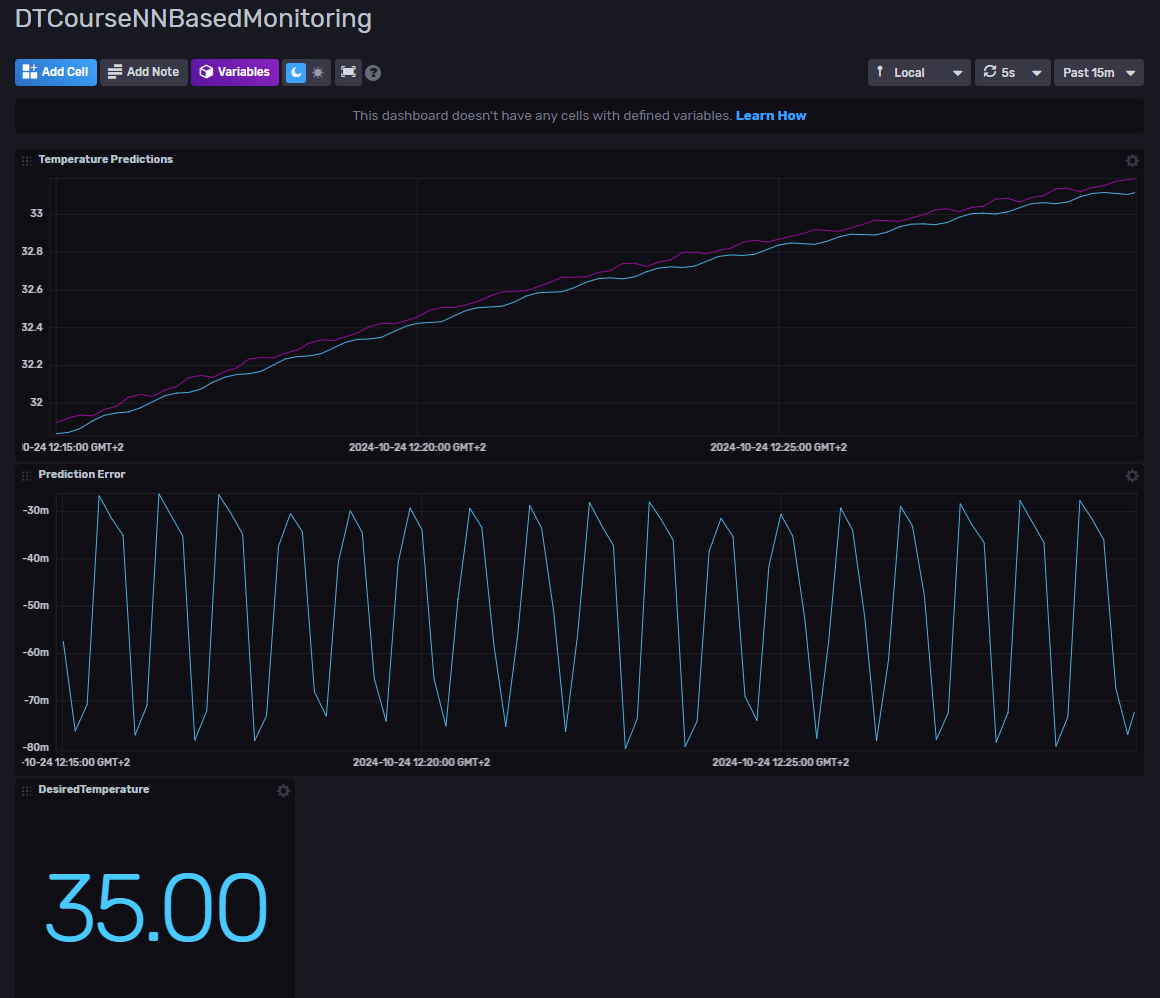

Let us simulate the opening of the lid:

In [20]:
from incubator.communication.server.rabbitmq import Rabbitmq
from mock_plant.mock_connection import MOCK_G_BOX
from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

lid_opening_factor = 1.0 # This is the factor by which the lid is opened. It's a value between 0.0 (Fully closed) and 1.0 (Fully open).
assert 0 <= lid_opening_factor <= 1, "lid_opening_factor must be between 0 and 1."

default_g_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
new_gbox = default_g_box + 10*lid_opening_factor * default_g_box

# Send a message to the PT to simulate the lid opening by a factor
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(MOCK_G_BOX, {"G_box": new_gbox})

# Wait a bit for the message to be processed
time.sleep(5)

# Check that the PT Reconfiguration Service has not crashed
assert temperature_prediction_service_proc.poll() is None, "temperature_prediction_service_proc has crashed"

In [14]:
# Print contents of log file to verify that the service is running
with open('NNBasedMonitoringService.log', 'r') as f:
    print(f.read())

# Check if the process is still running
assert temperature_prediction_service_proc.poll() is None

2024-10-24 11:41:38.246 INFO NNBasedMonitoringService : setup complete.
2024-10-24 11:41:40.668 INFO NNBasedMonitoringService : First message received.
2024-10-24 11:41:40.668 DEBUG NNBasedMonitoringService : step
2024-10-24 11:41:40.669 DEBUG NNBasedMonitoringService : prediction not step done yet. Waiting for more data.
2024-10-24 11:41:43.668 DEBUG NNBasedMonitoringService : step
2024-10-24 11:41:43.670 DEBUG NNBasedMonitoringService : prediction step done. Time(ns): 1729762903622176200, Heater: 1, Temp: 21.599959248388544, Room Temp: 21.0, New Temperature: 21.694812774658203
2024-10-24 11:41:46.680 DEBUG NNBasedMonitoringService : step
2024-10-24 11:41:46.680 DEBUG NNBasedMonitoringService : prediction step done. Time(ns): 1729762906626744300, Heater: 1, Temp: 21.621752111070915, Room Temp: 21.0, New Temperature: 21.71657371520996
2024-10-24 11:41:49.671 DEBUG NNBasedMonitoringService : step
2024-10-24 11:41:49.671 DEBUG NNBasedMonitoringService : prediction step done. Time(ns): 17

You should now see a behavior like the following:

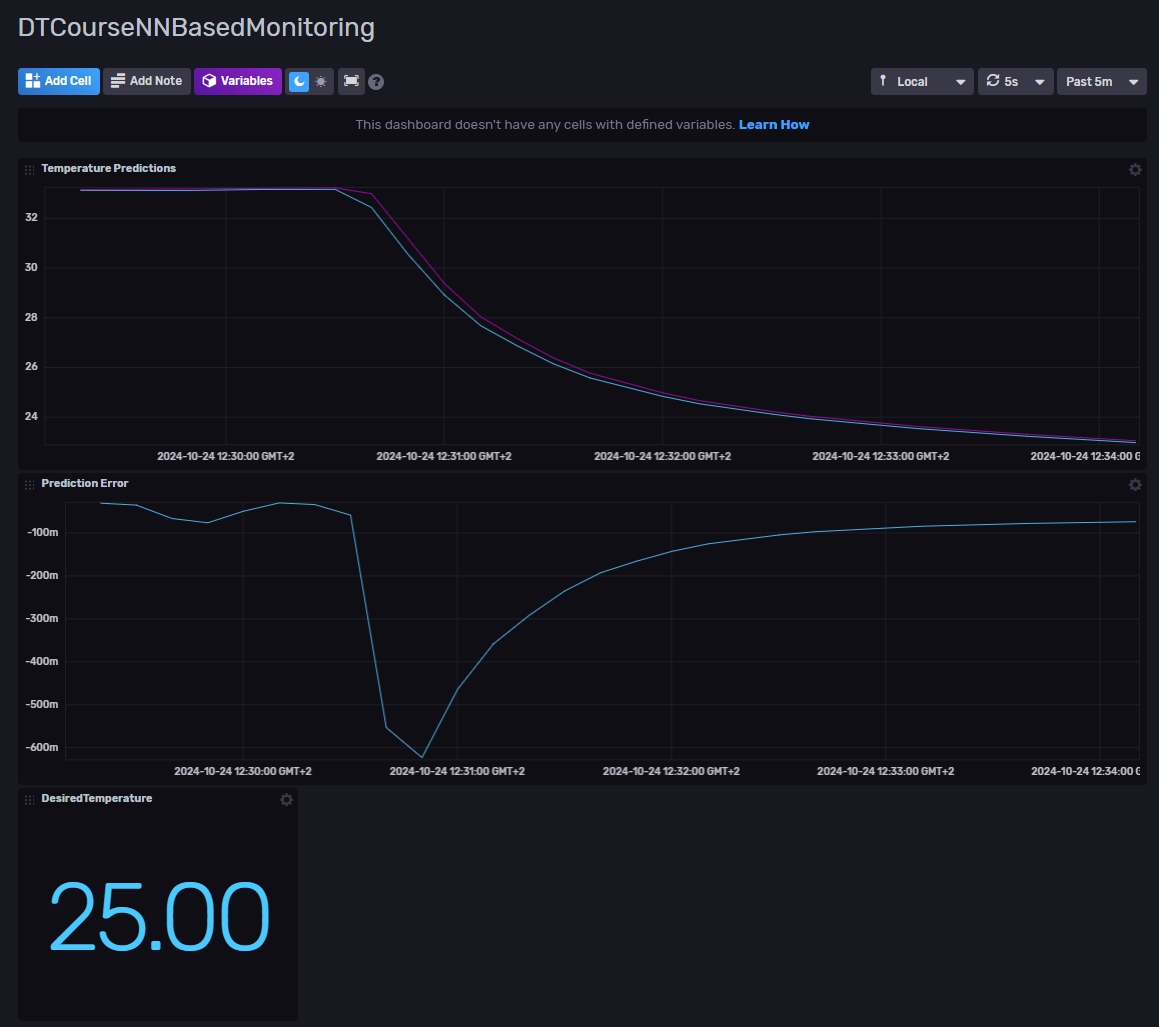

In [ ]:
# Restore lid and controller settings
from incubator.communication.shared.protocol import ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS

default_g_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
new_temperature_desired = 35.0

# Send a message to the PT to simulate the lid opening by a factor
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(MOCK_G_BOX, {"G_box": default_g_box})
    rabbitmq.send_message(ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS, {"temperature_desired": new_temperature_desired})

# Wait a bit for the message to be processed
time.sleep(5)

In [22]:
temperature_prediction_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
temperature_prediction_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert temperature_prediction_service_proc.returncode is not None, 'Process has not exited'